## Drought analysis at NUTS-0 level
In this notebook we show how to estimate the drought impacts by fitting a power law curve. Such "damage" function will depict the relationship between the country median drought frequency and the loss as a fraction of the exposed value of sensitive sectors.

The steps are the following:

1. Import configuration file and save parameters.
2. Import drought frequency data from parquet.
3. Import drought impact data, filter according to the configuration file and extract the drought frequency median for country and year.
4. Estimate the parameters of the power law based on the historical data.
5. Calculate the estimates of economic damages for all climate models (for the baseline).

Here the list of needed packages

In [91]:
import pandas as pd
import os
import re
import configparser
import sys
import numpy as np

### Read configuration file

Configuration file contains several parameters to filter the drought impact data in different ways as well as some other configuration fields. We developed a simple class to read all input parameters. The class is named `conf_ini` and is located in the scripts folder. Let's import the class:

In [92]:
sys.path.append('scripts')
from conf import conf_ini

In [93]:
# uncomment to show the class info
#help(conf_ini)

In [94]:
my_params = conf_ini("conf/conf.ini")

In [5]:
my_params.drought_analysis

{'prj_median_threshold': 0.5,
 'peseta_inputs': True,
 'filter': {'eu_only': True,
  'loss_threshold': 50.0,
  'year_threshold': 1989,
  'events': ['drought', 'heatwave']}}

### Import parquet file
Our frequency data are saved in the parquet format, which is provided by [apache](https://parquet.apache.org/). We can use pandas with the 'fastparquet' engine to open and access the data.

In [6]:
# filename
db_fn = "historical_zonal_stats_NUTS0.parquet" 
db_path = os.path.join(my_params.generic['db_path'],db_fn)

In [7]:
# open file
df = pd.read_parquet(db_path, engine='fastparquet')

In [8]:
df.NUTS_ID.unique()

array(['CZ', 'DE', 'DK', 'AL', 'CY', 'BG', 'AT', 'BE', 'EE', 'EL', 'ES',
       'FI', 'FR', 'HR', 'CH', 'HU', 'IE', 'IS', 'IT', 'LV', 'ME', 'MT',
       'MK', 'LT', 'LU', 'NL', 'NO', 'SI', 'LI', 'PL', 'RS', 'SE', 'SK',
       'TR', 'UK', 'PT', 'RO', 'BA'], dtype=object)

In [9]:
# we remove values above 0.5. Such values as intended as not representing a loss and therefore not considered.
#df = df[df["med"]<0.5]

In [10]:
final = df

### Import drought impact data and extract the drought frequency median for country and year.

Drought impact data are available from a csv table which contains all events of drought or similar in the european continent.

We can filter the events based on the configuration parameters in the configuration file. For example, the following map shows the available events with the following constraints:

| Parameter's name | Value |
| ---------------- | ----- |
| year_threshold   | 1989  |
| loss_threshold   | 100   |
| eu_only          | True  |
| events           |Drought|


<img src="png/drought_intensity_100M_countries.png" width="1000">

In [11]:
# if we want to work with PESETA IV inputs
if(my_params.drought_analysis["peseta_inputs"]):
    df_grouped = pd.read_csv("csv/peseta_inputs.csv")
else:
    # otherwise import the CSV raw file with all impact data
    filename_m= r"csv/drought_impact_all.csv"
    df_mre = pd.read_csv(filename_m)

In [12]:
my_params.drought_analysis["peseta_inputs"]

True

We want to add a few columns to the table to be able to differentiate between EU and not EU, and to add the alpha-2 ISO name

In [13]:
filename_a = r"csv/alpha2Name.csv"
df_alpha = pd.read_csv(filename_a)

In [14]:
# Create dictionaries and functions to populate the new columns using the apply method
dict_eu=dict(zip(df_alpha['ISO3'],df_alpha['EU28']))
dict_iso=dict(zip(df_alpha['ISO3'],df_alpha['ISO2']))
dict_alpha=dict(zip(df_alpha['ISO2'], df_alpha['Name']))

# small function to return the dictionaries value based on the key
def is_eu(dfs):
    return dict_eu[dfs['Country ISO3']]
def iso_2(dfs):
    return dict_iso[dfs['Country ISO3']]    
# small function to return country name
def country_name(dfs, cc):
    return dict_alpha[dfs[cc]]

We are now ready to filter the table using the parameter in the conf file.

In [15]:
drought_data = my_params.drought_analysis["filter"]
print("The following filter will be applied")
print(drought_data)

The following filter will be applied
{'eu_only': True, 'loss_threshold': 50.0, 'year_threshold': 1989, 'events': ['drought', 'heatwave']}


In [16]:
if(not my_params.drought_analysis["peseta_inputs"]):
    # use the apply function of pandas to make the new column
    df_mre['is_eu'] = df_mre.apply(is_eu, axis = 1)
    df_mre['ISO_2'] = df_mre.apply(iso_2, axis = 1)

    df_filtered = df_mre[(df_mre["Year"]>drought_data['year_threshold']) & 
                         (df_mre["losses"]>drought_data['loss_threshold']) & 
                         [len(set([word.strip().lower() for word in l.split(",")])&set(drought_data['events']))>0 for l in df_mre['Event Text']]].copy()
    # In case the analysis is only for EU + UK, let's remove the countries outside the EU + UK
    if(drought_data['eu_only']):
        df_filtered = df_filtered[df_filtered['is_eu']]

In [17]:
# uncomment to see the results
#df_filtered

In [18]:
# uncomment to save the new table
#df_filtered.to_csv("new_impact_data.csv")

Finally, if i have more than one drought event per year, i should merge such events into one, by summing the respective losses.

In [19]:
if(not my_params.drought_analysis["peseta_inputs"]):
    # grouping events
    df_to_group = df_filtered[["ISO_2","Year","losses"]].copy()
    df_grouped = df_to_group.groupby(['ISO_2','Year'])

In [20]:
# check if any group as more than one event
# df_grouped.count().reset_index().query("losses>1")

In [21]:
if(not my_params.drought_analysis["peseta_inputs"]):
    # if any, group them
    df_grouped = df_grouped.sum().reset_index()

In [22]:
df_grouped["country_name"] = df_grouped.apply(country_name, args=("ISO_2",),axis=1)

Now we are ready to calculate the loss as a fraction. The steps needed are the following:

* Import the exposed sensitivity values
* Add them to the filtered and grouped table
* Calculate the loss as a fraction of such values

In [23]:
# import the CSV
filename_m = r"csv/exposed_sensitivity_NUTS_1.csv"
df_exposed = pd.read_csv(filename_m)
dict_exp=dict(zip(df_exposed['ISO_2'],df_exposed['Sensitivity']))

In [24]:
# function to add the sensitivity value to each row of the events table
def get_exp(dfs):
    try: 
        expv = float(dict_exp[dfs['ISO_2']])
    except:
        expv = np.nan
    return expv

In [25]:
df_grouped['sensitivity'] = df_grouped.apply(get_exp, axis = 1)

Now we can calculate the fraction value

In [26]:
df_grouped['fraction'] = df_grouped['losses']/df_grouped['sensitivity']

In [27]:
# final table
df_grouped = df_grouped.sort_values("fraction")

In [28]:
def add_med(df):
    value =0 
    try:
        value=float(final.query("NUTS_ID==@df.ISO_2 and year==@df.Year").med)
    except:
        value=-999
    return value

In [29]:
df_grouped['med'] = df_grouped.apply(add_med, axis = 1)

In [30]:
#df_grouped['country'] = df_grouped.apply(country_name, args=("ISO_2",), axis = 1)

In [31]:
#df_grouped.to_csv("med_CM.csv")

In [32]:
df_grouped

,ISO_2,Year,losses,country_name,sensitivity,fraction,med
39,ES,2009,169.657531,Spain,31220.0,0.005434,0.413097
41,ES,2015,177.685193,Spain,31220.0,0.005691,0.477742
14,IT,2006,455.745423,Italy,45938.0,0.009921,0.520275
42,ES,2016,314.394790,Spain,31220.0,0.010070,0.493547
13,IT,1997,1000.940996,Italy,45938.0,0.021789,0.376713
23,RO,2001,184.290000,Romania,8083.0,0.022800,0.236878
15,IT,2012,1081.000000,Italy,45938.0,0.023532,0.294271
30,SK,2012,79.847153,Slovakia,3265.0,0.024455,0.484501
38,ES,2005,920.859606,Spain,31220.0,0.029496,0.172027
18,PL,2003,414.131728,Poland,12593.0,0.032886,0.361522


Now i can iterate through all the drought events and find the **median** value of drought frequency for the specific country and the specific year. We save the values in one list of tuples.

In [33]:
x_y_value = []
#y_value = []
for _, row in df_grouped.iterrows():
    # if the fraction of losses is higher than 0.5
    if(row.med > 0.5):
        print("excluding the following row:\n{0}".format(row))
    else:
        med = final.query("year==@row.Year and NUTS_ID==@row.ISO_2").med
        if(not med.empty):
            x_y_value.append((float(med),float(row.fraction)))
        else:
            print("excluding the following row as the drought median is above 0.5:\n{0}".format(row))

excluding the following row:
ISO_2                   IT
Year                  2006
losses          455.745423
country_name         Italy
sensitivity        45938.0
fraction          0.009921
med               0.520275
Name: 14, dtype: object
excluding the following row as the drought median is above 0.5:
ISO_2                 FR
Year                1989
losses            2780.0
country_name      France
sensitivity      48007.0
fraction        0.057908
med               -999.0
Name: 7, dtype: object


In [34]:
#len(x_y_value)

In [35]:
#x_y_value

## Base curve fitting

In addition to plotting data points from our observations and models, we must often fit them to a theoretical model to extract important parameters. In this case we will use a  __power-law__.

`curve_fit` method is used to estimate the parameters for the power law

In [36]:
# importing modules.
from scipy.optimize import curve_fit
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

The general formula of the power law can be expressed as:
$$y=ax^b$$

First, we define the function for the power law in python

In [37]:
# Function to calculate the power-law with constants a and b
def power_law(x, a, b):
    return a*np.power(x, b)

In [38]:
#power_law(0.365138, parameter_a_paper, parameter_b_paper) * 2000

In [39]:
# to use the exact peseta median values uncomment this
#median_str = "0.0181	0.24365	0.26385	0.10643	0.28862	0.02242	0.10578	0.30425	0.22983	0.28296	0.02583	0.0561	0.47659	0.39671	0.42441	0.2608	0.0566	0.05048	0.37318	0.10734	0.02202	0.07051	0.26963	0.28281	0.38584	0.31186	0.03946	0.21791	0.23632	0.33989	0.46882	0.38046	0.15267	0.47553	0.35829	0.21763	0.08956	0.37677	0.14022	0.38941	0.2059	0.46321	0.49902"
#sen_loss_str ="0.121446901461531	0.279399431229263	0.115118778762771	0.464052698720181	0.044057351708753	0.0828589296146767	0.250050308418772	0.0579082217176662	0.0965496008668505	0.0352861634143614	0.304963601883235	0.177482187671352	0.0414630019895263	0.0217889046482376	0.00992085807300785	0.0235316627286041	0.209687510430815	0.420558594852716	0.0304531015698578	0.0487902297369645	0.356085937046095	0.0747371088399698	0.103548290342262	0.0227997030805394	0.0763239221969144	0.105492776206919	0.730263134235891	0.0422540387605263	0.179499002121022	0.0566698973395268	0.0244554832440829	0.0591839537290976	0.0834356527107162	0.0365099755695067	0.0404620073991031	0.0471349848161435	0.0529673324484305	0.14363587010386	0.0294958233867673	0.00543425787473591	0.0339723927941819	0.00569138990347745	0.0100703007696731"

#median_v = [float(i) for i in median_str.split()]
#sen_loss_v = [float(i) for i in sen_loss_str.split()]
#x_y_value = list(zip(median_v,sen_loss_v))

Then we convert our python list to np array and sort it by x values

In [40]:
x_y = np.array(x_y_value)
x_y = x_y[x_y[:,0].argsort()]
# save x as sep array
x = x_y[:, 0]
# save y as sep array
y = x_y[:,1]

In [41]:
#x_y

__plotting__ First we plot directly from pandas using interactive Bokeh element

In [42]:
#from bokeh.plotting import figure, show
import pandas_bokeh
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row 
from bokeh.plotting import figure

output_notebook()

Loading BokehJS ...

In [43]:
#x_y_value

In [44]:
df_plot = pd.DataFrame(x_y_value, columns =['frequency', 'damage']) 

In [45]:
df_plot.iloc[39]

frequency    0.124678
damage       0.467943
Name: 39, dtype: float64

In [46]:
len(df_plot[df_plot["damage"]<0.8])

41

In [47]:
#y_range=(0, 0.4),
p = figure(plot_width=1000, plot_height=600, title = "prova",tools="pan,wheel_zoom,box_zoom,reset,hover")
p.circle('frequency','damage',source=df_plot,fill_alpha=0.2, size=10)
#df_plot.circle(x='frequency', y='damage')

GlyphRenderer(id='1039', ...)

In [48]:
show(p)

Then we plot the "normal way" using matplotlib

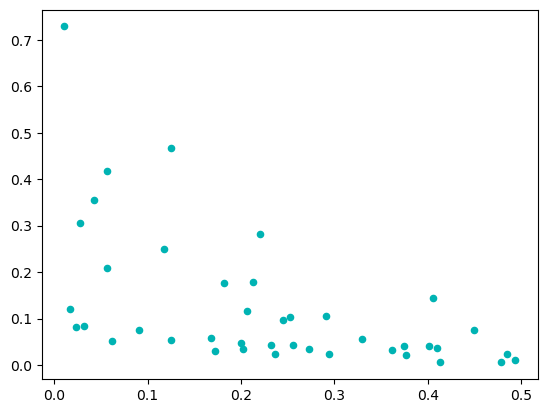

In [49]:
# Plot the  data
fig, ax = plt.subplots()
#plt.xlim([0,1])
ax.scatter(x, y, s=20, color='#00b3b3', label='Data')

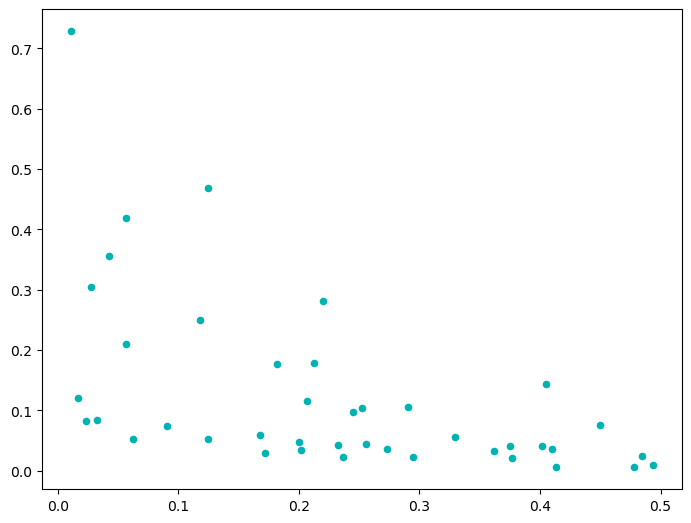

In [50]:
# Plot the  data
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
#plt.xlim([0,1])
ax.scatter(x, y, s=20, color='#00b3b3', label='Data')

An often more-useful method of visualizing exponential data is with a logarithmic plot since it linearizes the data. To set the scale of the x and y-axis from linear to logarithmic, we add the following line:

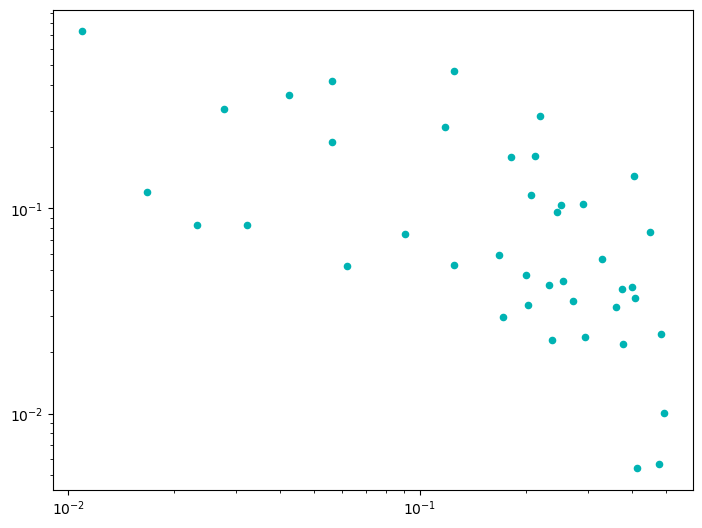

In [51]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# Set the x and y-axis scaling to logarithmic
ax.set_xscale('log')
ax.set_yscale('log')
# Edit the major and minor tick locations of x and y axes
ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
# Set the axis limits TODO
#ax.set_xlim(10, 1000)
#ax.set_ylim(1, 100)
ax.scatter(x, y, s=20, color='#00b3b3', label='Data')

We can now fit our data to the power law function to extract the a and b parameters, and superimpose the fit on the data. Note that although we have presented a log plot above, we have not actually changed the x and y-data - we have only changed the scale of the x and y-axis. So, we are still fitting the non-linear data, which is typically better as linearizing the data before fitting can change the residuals and variances of the fit.

We can use two different approach to fit to the curve. `curve_fit` from scipy and `model` from lmfit. The latter one allows us to easily specify the confidence intervals as well

__METHOD 1:__  
__curve_fit__

INPUTS:

* `f` — function used for fitting (in this case exponential)
* `xdata` — array of x-data for fitting
* `ydata` — array of y-data for fitting
* `p0` — array of initial guesses for the fitting parameters (both a and b as 0)
* `bounds` — bounds for the parameters (-∞ to ∞)

OUTPUTS:

* `pars` — array of parameters from fit (in this case [a, b])
* `cov` — the estimated covariance of pars which can be used to determine the standard deviations of the fitting parameters (square roots of the diagonals)

In [52]:
# TODO MAKE IT WEIGHTED
pars, pcov = curve_fit(f=power_law, xdata=x, ydata=y, p0=[0, 0], bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(pcov))
# Calculate the residuals
res = y - power_law(x, *pars)

In [53]:
if(False):
    from scipy import stats
    # Define confidence interval.
    ci = 0.95
    # Convert to percentile point of the normal distribution.
    # See: https://en.wikipedia.org/wiki/Standard_score
    pp = (1. + ci) / 2.
    # Convert to number of standard deviations.
    nstd = stats.norm.ppf(pp)
    print(nstd)
    popt_up = pars + nstd * stdevs
    popt_dw = pars - nstd * stdevs

We can extract the parameters and their standard deviations from the `curve_fit` outputs, and calculate the residuals by subtracting the calculated value (from our fit) from the actual observed values (our dummy data)

In [54]:
print("Fit parameters and standard deviations:")
print("a=", round(pars[0], 5), "+-", round(stdevs[0], 3))
print("b=", round(pars[1], 5), "+-", round(stdevs[1], 3))
print("Paper parameters:")
print("a= 0.04756")
print("b= -0.48652")
parameter_a = pars[0]
parameter_b = pars[1]
parameter_a_paper = 0.04756
parameter_b_paper = -0.48652

Fit parameters and standard deviations:
a= 0.0364 +- 0.014
b= -0.56963 +- 0.109
Paper parameters:
a= 0.04756
b= -0.48652


__METHOD 2:__  
__Model.fit__

INPUTS:

* `data` (array_like) – Array of data to be fit.
* `params` (Parameters, optional) – Parameters to use in fit (default is None).
* `weights` (array_like, optional) – Weights to use for the calculation of the fit residual [i.e., weights*(data-fit)]. Default is None; must have the same size as data.
* `method` (str, optional) – Name of fitting method to use (default is ‘leastsq’).
* `iter_cb` (callable, optional) – Callback function to call at each iteration (default is None).
* `scale_covar` (bool, optional) – Whether to automatically scale the covariance matrix when calculating uncertainties (default is True).

(...)

In [55]:
import lmfit
from lmfit import Model

In [56]:
# define the fitting model
model = Model(power_law)
params = model.make_params(a=1,b=1) 

In [57]:
# fit to curve
result = model.fit(y, params, x=x)

In [58]:
# show summary of results
print(result.fit_report())

[[Model]]
    Model(power_law)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 41
    # variables        = 2
    chi-square         = 0.54335089
    reduced chi-square = 0.01393207
    Akaike info crit   = -173.266453
    Bayesian info crit = -169.839309
    R-squared          = 0.39329579
[[Variables]]
    a:  0.03640002 +/- 0.01382905 (37.99%) (init = 1)
    b: -0.56962857 +/- 0.10854546 (19.06%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = 0.950


Results are the same as before. Let's now calculate the __confidence intervals__ as well

In [59]:
ci = result.conf_interval()
print(lmfit.printfuncs.ci_report(ci,with_offset=True))

      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a:  -0.03178  -0.02382  -0.01315   0.03640  +0.01598  +0.03573  +0.06110
 b:  -0.51966  -0.27953  -0.12299  -0.56963  +0.10962  +0.21832  +0.33858


Let's now plot the fitted curve.
`*pars` — allows us to unroll the pars array, i.e. [a, b] gets inputted as a, b

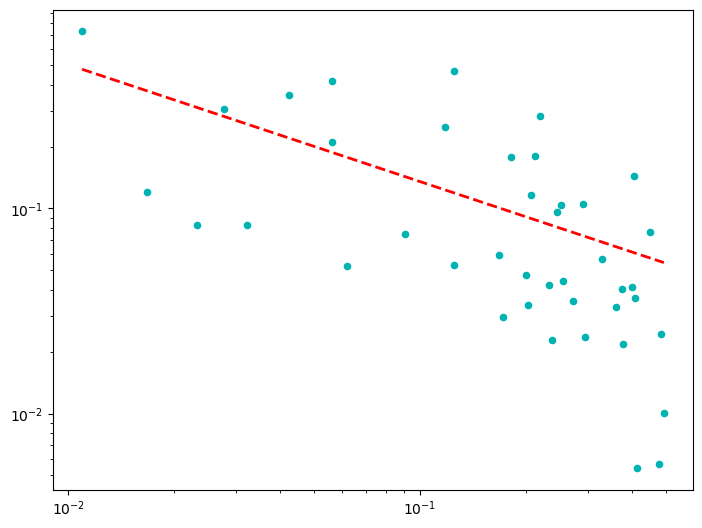

In [60]:
# Plot the fit data as an overlay on the scatter data
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# Set the x and y-axis scaling to logarithmic
ax.set_xscale('log')
ax.set_yscale('log')
# Edit the major and minor tick locations of x and y axes
ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
# Set the axis limits
#ax.set_xlim(10, 1000)
#ax.set_ylim(1, 100)
ax.scatter(x, y, s=20, color='#00b3b3', label='Data')
ax.plot(x, power_law(x, *pars), linestyle='--', linewidth=2, color='red')

Finally let's visualize the curve not log-scaled

In [61]:
# for now we just use the std deviation values to calculate an interval
conf =[]
conf.append([pars[0]-stdevs[0],pars[1]+stdevs[1]])
conf.append([pars[0]+stdevs[0],pars[1]-stdevs[1]])

(0.0, 0.5)

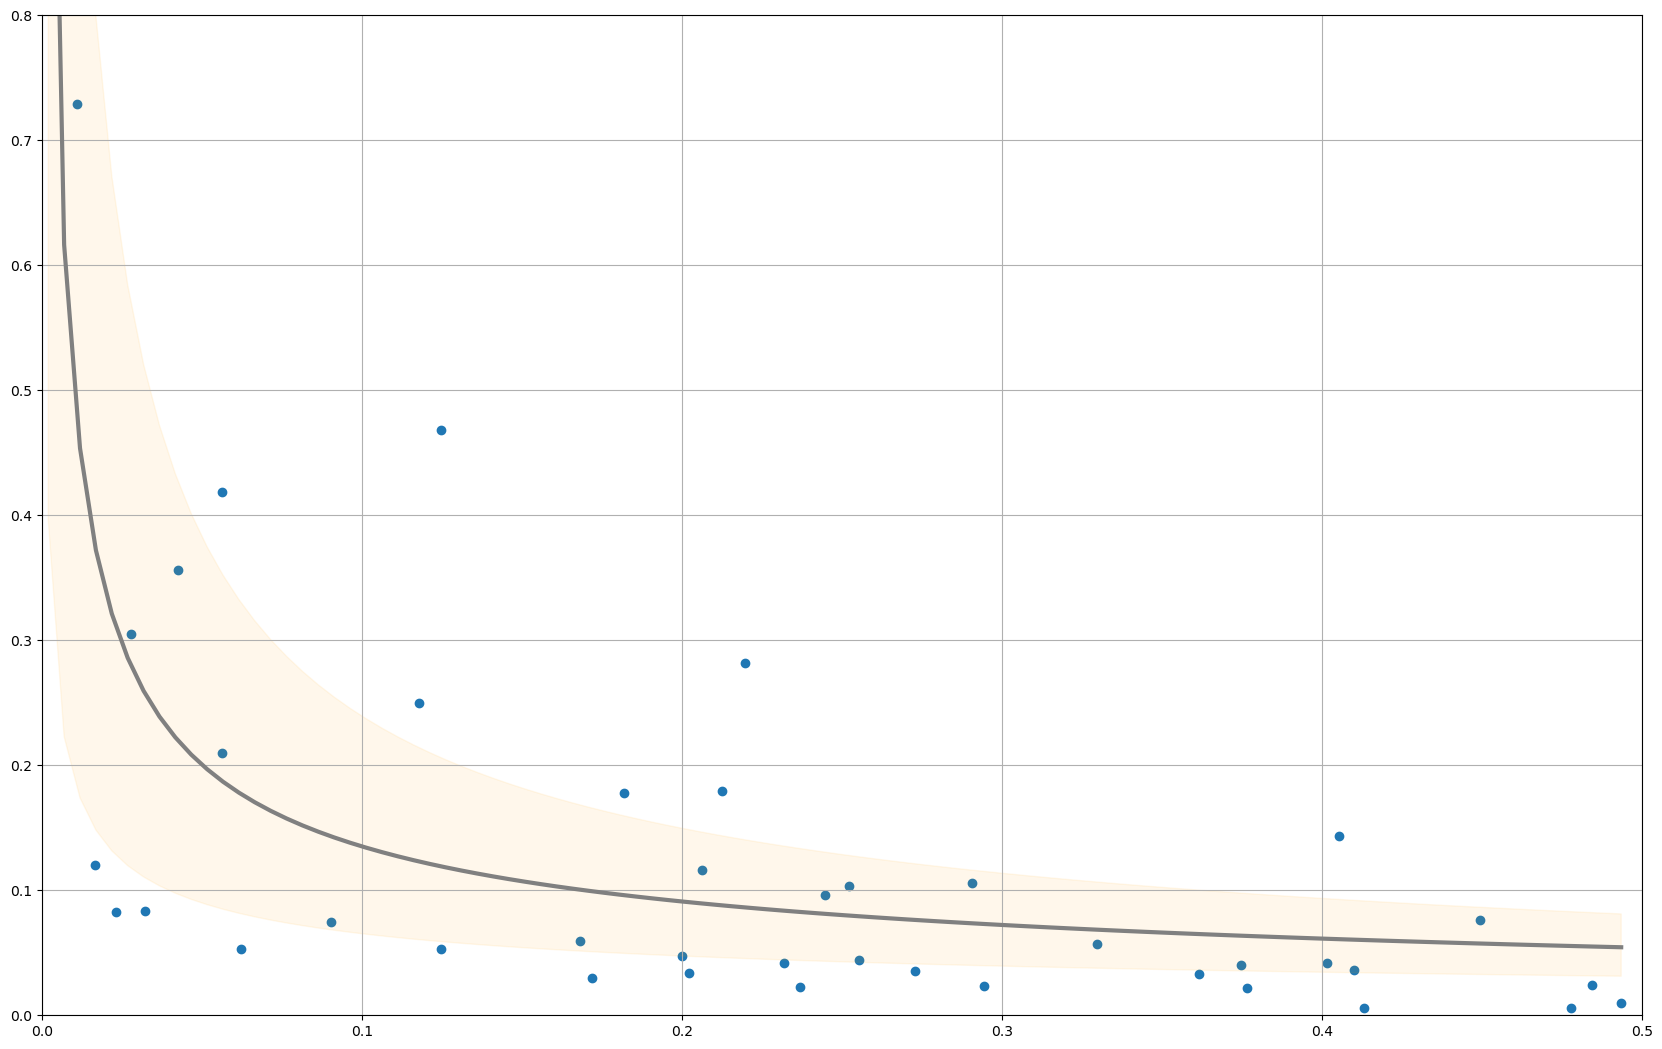

In [62]:
fig = plt.figure(figsize=(16,10))

ax = fig.add_axes([0.0, 0, 1, 1])
x_ranged = np.linspace(0.002,x.max(), 100) 

# plotting obs
ax.scatter(x,y)

# plotting fitted curve
ax.plot(x_ranged, power_law(x_ranged, *pars), linewidth=3, color='greY')

# plotting the confidence intervals (std devs)
ax.fill_between(x_ranged, power_law(x_ranged, *conf[0]), power_law(x_ranged, *conf[1]),
                 color = 'orange', alpha = 0.08)
plt.grid(True)
plt.ylim(0,0.8)
plt.xlim(0,0.5)

## Estimates of economic damages

Estimates of direct economic damages are expressed in €2015 values, and they were obtained as follows. For all climate realizations of the ensemble, we combine for each 30-year time window (baseline and periods centred on the GWLs) the hazard, exposure and damage function in the following way. For each year of a 30-year time window, the median frequency of the simulated annual  minimum flow is obtained over all river pixels with upstream area >1,000 km2 in 
a country. This value is then plugged into the damage function (central estimate in Supplementary Fig. 4, x-axis) to determine the loss as a fraction of the exposed sensitive value. So in country A, an event in year i with a probability to happen once every 5 years (frequency = 0.2, or return period of 5 years), would result in a 10% loss of the exposed sensitive value in that country. Multiplication with the present (baseline, Supplementary Table 4) or future (end of century, Supplementary  Table 5) exposed sensitive value for country A then provides a quantitative estimate  of the drought losses for country A in year i. For each climate realization, the  country expected annual damage at the GWLs was then obtained by taking the  average loss over the 30 years of estimated annual losses in the respective periods.  We note that when considering extremes, it is important to take the average impact  over all simulated events and not the median, as there is large skew in the impact  distribution (inherent to extreme events) and the low-probability high-impact  events have an important weight in the expected annual losses. The uncertainty in  the fitted damage function (dotted lines in Supplementary Fig. 4) was translated  into impact estimates through loss estimations for the 5% and 95% uncertainty  bounds of the fitted vulnerability function for each climate realization. The total uncertainty in our damage estimates thus reflects the variability in future climate at the warming levels as defined by the climate ensemble and the uncertainty in the relation between damages and drought hazard.

Here is the path to the parquet file containing the median frequency data we are interested in

In [63]:
prj_path = os.path.join(my_params.generic["db_path"],"zonal_stats_NUTS0_tot.parquet")

In [64]:
prj_df = pd.read_parquet(prj_path, engine='fastparquet')

In [65]:
prj_df.columns

Index(['model', 'rcp', 'year', 'NUTS_ID', 'med'], dtype='object')

In [66]:
#prj_df.query("model=='SMHI-RCA4_BC_MOHC-HadGEM2-ES' and rcp==85 and year==1981").sort_values("NUTS_ID")

In [67]:
# filter to baseline
prj_df = prj_df[prj_df['year']<2011]

Values of 0.002 are already really low (as it means a return period of 500 years). We decided to not included values that are lower than that.

In [68]:
# cap to 0.002 as lowest
prj_df.loc[(prj_df["med"] < 0.002) & (prj_df["med"] > 0.0), "med"] = 0.002

We are ready to calculate the drought losses for country _a_ in year _i_ for each climate model and rcp.

In [69]:
def calculate_loss(element):
    if(element.NUTS_ID in dict_exp):
        if(element.med > 0 and element.med <my_params.drought_analysis["prj_median_threshold"]):
            return power_law(element.med, parameter_a, parameter_b) * dict_exp[element.NUTS_ID]
        else:
            return 0.0
    else:
        return np.nan

In [70]:
prj_df["loss"] = prj_df.apply(calculate_loss, axis=1)

Then we calculate the mean over the 30 years window for each model

In [71]:
prj_grouped_final = prj_df.groupby(["model","rcp","NUTS_ID"]).mean(numeric_only=True).reset_index().drop("year",axis=1)

In [72]:
prj_grouped_final

,model,rcp,NUTS_ID,med,loss
0,CLMcom-CCLM4-8-17_BC_CNRM-CERFACS-CNRM-CM5,45,AL,0.506061,81.141439
1,CLMcom-CCLM4-8-17_BC_CNRM-CERFACS-CNRM-CM5,45,AT,0.476331,439.544722
2,CLMcom-CCLM4-8-17_BC_CNRM-CERFACS-CNRM-CM5,45,BE,0.475236,391.444756
3,CLMcom-CCLM4-8-17_BC_CNRM-CERFACS-CNRM-CM5,45,BG,0.485195,114.054717
4,CLMcom-CCLM4-8-17_BC_CNRM-CERFACS-CNRM-CM5,45,CH,0.488832,401.200207
...,...,...,...,...,...
809,SMHI-RCA4_BC_MPI-M-MPI-ESM-LR,85,SE,0.580758,459.387920
810,SMHI-RCA4_BC_MPI-M-MPI-ESM-LR,85,SI,0.518002,65.515332
811,SMHI-RCA4_BC_MPI-M-MPI-ESM-LR,85,SK,0.569237,82.116314
812,SMHI-RCA4_BC_MPI-M-MPI-ESM-LR,85,TR,0.372375,NaN


Finally, we get the mean of all models. We also drop non EU countries

In [73]:
results=prj_grouped_final.groupby("NUTS_ID").mean(numeric_only=True).reset_index().drop(["rcp","med"],axis=1).dropna()

In [74]:
# adding the country name
results['country_name'] = results.apply(country_name, args=("NUTS_ID",), axis = 1)

Here the final results!

In [75]:
#results

In [76]:
# save to file
results.to_parquet(os.path.join(my_params.generic['result_path'],'nuts_0.parquet'), engine='fastparquet')

In [77]:
def country_exp(dfs):
    return dict_exp[dfs['country_code']]

### Compare results with paper

In [78]:
# paper
d = {'country': ['Austria','Belgium','Bulgaria','Croatia','Cyprus','Czech Republic','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland','Italy','Latvia','Lithuania','Luxembourg','Malta','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia','Spain','Sweden','United Kingdom'], 
     'loss': [244,210,89,72,38,169,121,14,66,1244,996,326,162,122,1395,18,29,20,13,265,338,252,388,84,45,1487,157,686]}
df = pd.DataFrame(data=d)
inv_map = {v: k for k, v in dict_alpha.items()}

In [79]:
def country_code(dfs):
    return inv_map[dfs['country']]

In [80]:
df['country_code'] = df.apply(country_code, axis = 1)

In [81]:
# use the apply function of pandas to make the new column
#df['exp'] = df.apply(country_exp, axis = 1)
#df['med_ref'] = pow((df['loss'] / df['exp'])/parameter_a_paper,1/parameter_b_paper)

In [82]:
results = results.rename(columns={"loss":"cm_loss","NUTS_ID":"country_code"}).drop(["country_name"],axis=1)

In [83]:
f_results = pd.merge(df,results,how='inner',on='country_code')

In [84]:
f_results["diff"] = round(f_results.cm_loss - f_results.loss,0)

In [85]:
f_results.drop("country_code",axis=1).style.background_gradient(axis=None,cmap='YlOrRd', subset=['diff']) 

,country,loss,cm_loss,diff
0,Austria,244,587.934541,344.000000
1,Belgium,210,487.240796,277.000000
2,Bulgaria,89,124.582943,36.000000
3,Croatia,72,112.487521,40.000000
4,Cyprus,38,59.975740,22.000000
5,Czech Republic,169,359.022153,190.000000
6,Denmark,121,306.824764,186.000000
7,Estonia,14,24.067631,10.000000
8,Finland,66,238.172483,172.000000
9,France,1244,3293.559629,2050.000000


### Questions

1. Same model and rcp does have differente river pixels in the raster. How to consider when pixel's are not there, even at NUTS-0? [solved]
2. How is it weighted? 
3. Looking at the results of the paper, and applying the inverse power law to them, i get values well above 1 for frequency. E.g. 61 for Sweden, 48 for Finland. How that can happen? my ones are all below 1 in average too.

### sandbox

In [86]:
#power_law(0.369,parameter_a, parameter_b) * 6586

In [87]:
#210/6586

In [88]:
#final_df = pd.DataFrame(listone, columns=['country_code','impact','fraction'])

In [89]:
#final_df[final_df['country_code']=='AT']

In [90]:
#prova_dbf = r"E:\mottaco\Documents\JRC\3. Data\1. Drought\LISFLOOD\projection\dbf\frq_table_droughtFrqDiagnostics_IPSL_INERIS_WRF331F_BC_rcp45_1990_NUTS3.dbf"

#dbf = Dbf5(prova_dbf, codec='utf-8')
# convert it to a pandas dataframe
#df = dbf.to_dataframe()

#dbf = Dbf5(r"E:\mottaco\Documents\Workspace\Drought_analysis\dbf\table_y1990_NUTS3.dbf", codec='utf-8')
# convert it to a pandas dataframe
#df2 = dbf.to_dataframe()

#prova_diff = list(set(df2.NUTS_ID) - set(df.NUTS_ID))

#prova_diff.sort()